In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from random import sample
from collections import defaultdict
from pathlib import Path
import networkx as nx
import pickle
from itertools import permutations, chain
import numpy as np
from random import sample
from gensim.models.keyedvectors import KeyedVectors
from gensim.similarities.index import AnnoyIndexer
from scipy.stats import spearmanr
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import unicodedata
import re
import string
import random

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)

In [4]:
%matplotlib inline

In [5]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")

# 単語の準備

In [7]:
%%time
embedding = KeyedVectors.load_word2vec_format('../input/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=10000)

CPU times: user 516 ms, sys: 4 ms, total: 520 ms
Wall time: 1.04 s


In [8]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    
# 大文字を全部小文字にする
# 無駄な空白や文字じゃないやつを全部消す
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r"", s)
    return s

In [9]:
%%time
# あらかじめ入力する単語を綺麗にしておく
# 全て小文字にして、a-z以外の単語を取り除く
normalized_words = set([normalizeString(word) for word in embedding.vocab.keys()]) & embedding.vocab.keys()

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 220 ms


In [10]:
n_train = int(len(normalized_words) * 0.9)
n_validate = int(len(normalized_words) * 0.05)
n_test = len(normalized_words) - n_train - n_validate

all_words = list(normalized_words)
train_words = set(sample(all_words, n_train))
validate_words = set(sample(list(set(all_words) - train_words), n_validate))
test_words = normalized_words - train_words - validate_words

In [11]:
n_train, n_validate, n_test, len(normalized_words)

(5647, 705, 707, 7059)

# バッチ処理

In [12]:
class GRUEncoder(nn.Module):
    def __init__(self, emb_dim, h_dim):
        super(GRUEncoder, self).__init__()
        self.emb_dim = emb_dim
        self.h_dim = h_dim
        
        self.emb = nn.Embedding(27, self.emb_dim) # a-z, paddingの合計27種類
        self.gru = nn.GRU(self.emb_dim, self.h_dim, batch_first=True, bidirectional=True)
        
    def init_hidden(self, b_size):
        h0 = torch.zeros(1*2, b_size, self.h_dim, device=device)
        return h0
    
    def forward(self, words, lengths):
        '''
        words(文字idxの列に変換したwords): tensor(b, s_len), wordsは文字数が長い順に並べ、0埋めをしておく
        length(文字数): tensor(b, 1), wordの文字数を長い順に並べたもの
        '''
        self.hidden = self.init_hidden(words.size(0))
        embed = self.emb(words)
        lengths = lengths.view(-1)
        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        packed_out, hidden = self.gru(packed_input, self.hidden)
        out = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)[0] # 0:out, 1: lengths
        # itokの実装では以下の計算を行なっていたが、元論文には無いので実行しない
        # out = out[:, :, :self.h_dim] + out[:, :, self.h_dim:] # 多分、正方向out + 逆方向outを計算
        return out # (b, s, h*2)

In [13]:
class Attn(nn.Module):
    ''' Single Attention'''
    def __init__(self, h_dim, linear_mid, linear_out=1):
        super(Attn, self).__init__()
        self.h_dim = h_dim
        
        self.main = nn.Sequential(
            nn.Linear(h_dim*2, linear_mid),
            nn.ReLU(True),
            nn.Linear(linear_mid, 1)
        )
        
    def forward(self, encoder_outputs):
        b_size = encoder_outputs.size(0)
        attn = self.main(encoder_outputs.contiguous().view(-1, self.h_dim*2)) # (b, s, h*2)→(b*s, h*2)→(b*s, 1)
        return F.softmax(attn.view(b_size, -1), dim=1).unsqueeze(2) # (b*s, 1)→(b, s)→(b, s, 1)

In [14]:
class AttnDecoder(nn.Module):
    def __init__(self, h_dim, linear_mid, linear_out=1, out_dim=300):
        super(AttnDecoder, self).__init__()
        
        self.attn = Attn(h_dim, linear_mid, linear_out)
        self.linear = nn.Linear(h_dim*2, out_dim)
        
    def forward(self, encoder_outputs):
        attn = self.attn(encoder_outputs)
        feats = (encoder_outputs * attn).sum(dim=1) # (b, s, h*2)*(b, s, 1)=(b, s, h*2)→(b, h*2)
        out = self.linear(feats) # (b, h*2)→(b, out)
        return out, attn

In [15]:
# ループを噛ませるとバッチを作るイテレータを生成する関数、ジェネレータを作る勉強
# forループの中でいちいちバッチを作るより高速化したり、必要なメモリ量が減るらしい
# 参考1: https://qiita.com/tomotaka_ito/items/35f3eb108f587022fa09
# 参考2: https://www.lifewithpython.com/2015/11/python-create-iterator-protocol-class.html←こちらに準拠
class DataIterator(object):
    def __init__(self, words, batch_len):
        self.words = list(words)
        self.n_words = len(words)
        self.batch_len = batch_len
    def __iter__(self):
        random.shuffle(self.words) # 学習の各epoch毎に、単語を並び替える
        for b_idx in range(0, self.n_words, self.batch_len):
            word_batch = self.words[b_idx:b_idx+self.batch_len] # 単語のバッチを取り出す
            
            target_tensor = torch.from_numpy(np.array([embedding[word] for word in word_batch])).to(device) # (b, 300)
            
            word_batch = [[string.ascii_lowercase.index(l)+1 for l in word] for word in word_batch] # 各単語の文字をindex化する
            word_lengths = torch.LongTensor([len(word) for word in word_batch], device=device) # 各単語の長さを測る
            word_tensor = torch.zeros((len(word_batch), word_lengths.max()), device=device).long() 
            for w_idx, (word, w_len) in enumerate(zip(word_batch, word_lengths)): # paddingで単語の長さを揃える
                word_tensor[w_idx, :w_len] = torch.LongTensor(word)
            word_lengths, perm_idx = word_lengths.sort(0, descending=True) # 単語の長さを降順に並び替える
            word_tensor = word_tensor[perm_idx] # バッチ内単語を単語の長さが長い順に並び替える
            
            yield word_tensor, word_lengths, target_tensor

In [16]:
def generate_validation_batch(words, batch_len):
    ''' 学習経過を観測するためのバッチ, trainとは別の単語群を用いる'''
    word_batch = random.sample(words, batch_len)
    target_tensor = torch.from_numpy(np.array([embedding[word] for word in word_batch])).to(device)      
    word_batch = [[string.ascii_lowercase.index(l)+1 for l in word] for word in word_batch]
    word_lengths = torch.LongTensor([len(word) for word in word_batch], device=device)
    word_tensor = torch.zeros((len(word_batch), word_lengths.max()), device=device).long() 
    for w_idx, (word, w_len) in enumerate(zip(word_batch, word_lengths)):
        word_tensor[w_idx, :w_len] = torch.LongTensor(word)
    word_lengths, perm_idx = word_lengths.sort(0, descending=True)
    word_tensor = word_tensor[perm_idx]
    return word_tensor, word_lengths, target_tensor

# 学習

In [96]:
emb_dim = 16
h_dim = 126
linear_mid = 64
learning_rate = 0.03
batch_len = 10
n_epoch = 100
print_every = 10

In [87]:
encoder = GRUEncoder(emb_dim, h_dim).to(device)
decoder = AttnDecoder(h_dim, linear_mid).to(device)

In [88]:
optimizer = optim.SGD(chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)

In [89]:
criterion = nn.MSELoss()

In [90]:
data_iterator = DataIterator(train_words, batch_len)

In [91]:
def train(train_iter, optimizer, criterion):
    epoch_loss = 0
    for i, (word_tensor, word_lengths, target_tensor) in enumerate(data_iterator):
        optimizer.zero_grad()
        encoder_outputs = encoder(word_tensor, word_lengths)
        output, attn = decoder(encoder_outputs)
        loss = criterion(output.view(-1, 300), target_tensor.view(-1, 300)) # (b, out_dim)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    epoch_loss = epoch_loss / (i+1) # ループを最後まで回したから、iには(ループ回数-1)が代入されている
    return epoch_loss

In [92]:
def validate(validate_words, criterion, batch_len=100): # batch_len: 評価用の単語群、サンプリングする
    with torch.no_grad():
        valid_loss = 0
        word_tensor, word_lengths, target_tensor = generate_validation_batch(validate_words, batch_len)
        encoder_outputs = encoder(word_tensor, word_lengths)
        output, attn = decoder(encoder_outputs)
        loss = criterion(output, target_tensor)
        valid_loss += loss
    return valid_loss

In [97]:
train_learning_curve = list()
valid_learning_curve = list()
for epoch in tqdm(range(n_epoch)):
    train_loss = train(data_iterator, optimizer, criterion)
    valid_loss = validate(validate_words, criterion)
    
    train_learning_curve.append(train_loss)
    valid_learning_curve.append(valid_loss)
    if epoch % print_every == 0:
        print("iter: {} train_loss: {:.5f} valid_loss: {:.5f}".format(epoch, train_loss, valid_loss))

iter: 0 train_loss: 0.02787 valid_loss: 0.02596
iter: 10 train_loss: 0.02786 valid_loss: 0.02722
iter: 20 train_loss: 0.02783 valid_loss: 0.02643
iter: 30 train_loss: 0.02783 valid_loss: 0.02850
iter: 40 train_loss: 0.02780 valid_loss: 0.02798
iter: 50 train_loss: 0.02780 valid_loss: 0.02858
iter: 60 train_loss: 0.02778 valid_loss: 0.02750
iter: 70 train_loss: 0.02778 valid_loss: 0.02863
iter: 80 train_loss: 0.02777 valid_loss: 0.02717
iter: 90 train_loss: 0.02776 valid_loss: 0.02702


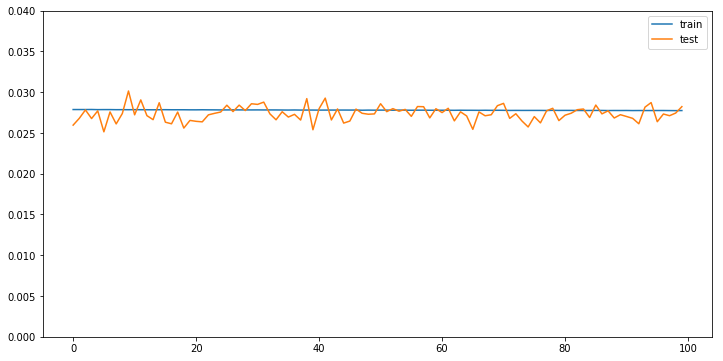

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_learning_curve, label='train')
ax.plot(valid_learning_curve, label='test')
ax.set_ylim(0, 0.04)
ax.legend()
plt.show()

In [75]:
tmp = [2,3,7,4,5,9,7,9,8,6]

In [76]:
tmp.index(max(tmp))

5

In [104]:
def predict(predict_word):
    word_tensor, word_lengths, _ = generate_validation_batch({predict_word}, batch_len=1)
    with torch.no_grad():
        encoder_outputs = encoder(word_tensor, word_lengths)
        output, attn = decoder(encoder_outputs)
        attn = attn.cpu().numpy().flatten()
    attn = list(attn)
    min_value = min(attn)
    attn_indexes = [idx for idx, value in enumerate(attn) if value > min_value*1.01]
    attn_splits = [predict_word[]]
    print('word: {}'.format(predict_word))
    print('attention: {}'.format([round(i, 3) for i in attn]))
    print('split: {}'.format(predict_word[:max_index], predict_word[max_index:]))
    print('')

In [125]:
def split_ing(predict_word):
    word_tensor, word_lengths, _ = generate_validation_batch({predict_word}, batch_len=1)
    with torch.no_grad():
        encoder_outputs = encoder(word_tensor, word_lengths)
        output, attn = decoder(encoder_outputs)
        attn = attn.cpu().numpy().flatten()
    attn = list(attn)
    max_index = attn.index(max(attn))
    print('word: {}'.format(predict_word))
    print('split: {} {}'.format(predict_word[:max_index-1], predict_word[max_index-1:]))
    print('')

In [122]:
[1,2,3,2,5,6].index(5)

4

In [118]:
'saying' in (train_words)

True

In [106]:
predict('saying')

word: saying
attention: [0.167, 0.163, 0.162, 0.166, 0.175, 0.167]
split: sayi ng



In [114]:
'working'[-3:]

'ing'

In [126]:
cnt = 0
for word in train_words:
    if word[-3:] == 'ing':
        split_ing(word)
        cnt += 1
        if cnt > 20:
            break

word: saying
split: say ing

word: staffing
split: staff ing

word: counseling
split: co unseling

word: lacking
split: lack ing

word: king
split: k ing

word: consisting
split: c onsisting

word: networking
split: network ing

word: rewarding
split: reward ing

word: wrongdoing
split: wr ongdoing

word: eliminating
split: eliminat ing

word: disturbing
split: disturb ing

word: thinking
split: think ing

word: nothing
split: noth ing

word: releasing
split: releasin g

word: blowing
split: blow ing

word: advancing
split: advanc ing

word: lighting
split: light ing

word: listing
split: list ing

word: crying
split: cry ing

word: demanding
split: demand ing

word: touring
split: tour ing

